Цель задания - исследовать датасет и визуализировать данные с помощью Seaborn

Описание полей датасета:
* ProjectID (число) - id проекта в рамках которого загружен файл, привязка к элементам другой таблицы
* UserID (число) - id пользователя, загрузившего файл, привязка к элементам другой таблицы
* uploadServerUnixTime (число) - время загрузки файла на сервер в формате UnixTime
* CompanyID (число) - id организации которой принадлежит пользователь, привязка элемента другой таблицы
* FileSize (число) - размер файла в байтах
* TypeDocs (строка) - раздел в который загружен файл

Есть организации-застройщики (CompanyID), в каждой из которых может быть несколько пользователей (UserID). Существуют проекты (ProjectID), к каждому из которых может иметь доступ несколько пользователей разных организаций (пользователь может иметь доступ к нескольким проектам). Внутри каждого проекта есть несколько разделов (TypeDocs), в который пользователь загружает файлы для организации.

## Открытие датасета

In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
storage_df = pd.read_csv('dataset_file_storage.csv', sep=';')

In [5]:
storage_df.head()

,ProjectID,UserID,uploadServerUnixTime,CompanyID,FileSize,TypeDocs
0,753919,27549,1582272443,753918,732686,6.Юридические документы
1,726628,26990,1582216416,726615,2484373,8.Другие документы
2,705607,26912,1571732077,703124,22,1.Основные документы
3,705605,26912,1571048621,703124,4,1.Основные документы
4,705605,26912,1570799210,703124,1030735,1.Основные документы


In [6]:
storage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852 entries, 0 to 1851
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ProjectID             1852 non-null   int64 
 1   UserID                1852 non-null   int64 
 2   uploadServerUnixTime  1852 non-null   int64 
 3   CompanyID             1852 non-null   int64 
 4   FileSize              1852 non-null   int64 
 5   TypeDocs              1852 non-null   object
dtypes: int64(5), object(1)
memory usage: 86.9+ KB


## Предобработка

Перед выполнением заданий необходимо импортировать требуемые для работы модули Python, загрузить датасет в датафрейм и выполнить его предварительную обработку:
* преобразовать столбец "uploadServerUnixTime" в пригодный для работы формат с помощь методов модуля datetime;
* на основе столбца "uploadServerUnixTime" добавить необходимые столбцы для группировки данных (месяц, день и т.п.);
* очистить датафрейм от неполных данных (есть записи за неполный месяц март);

In [7]:
storage_df.uploadServerUnixTime = storage_df.uploadServerUnixTime.apply(lambda timestamp: datetime.datetime.fromtimestamp(timestamp))

In [8]:
storage_df['year'] = storage_df.uploadServerUnixTime.apply(lambda datetime: datetime.year)
storage_df['month'] = storage_df.uploadServerUnixTime.apply(lambda datetime: datetime.month)
storage_df['day'] = storage_df.uploadServerUnixTime.apply(lambda datetime: datetime.day)
storage_df['weekday'] = storage_df.uploadServerUnixTime.apply(lambda datetime: datetime.weekday())
storage_df['hour'] = storage_df.uploadServerUnixTime.apply(lambda datetime: datetime.hour)
storage_df['date'] = storage_df.uploadServerUnixTime.apply(lambda datetime: datetime.date())

In [9]:
storage_df = storage_df.drop('uploadServerUnixTime', axis=1)

In [10]:
storage_df.head()

,ProjectID,UserID,CompanyID,FileSize,TypeDocs,year,month,day,weekday,hour,date
0,753919,27549,753918,732686,6.Юридические документы,2020,2,21,4,11,2020-02-21
1,726628,26990,726615,2484373,8.Другие документы,2020,2,20,3,19,2020-02-20
2,705607,26912,703124,22,1.Основные документы,2019,10,22,1,11,2019-10-22
3,705605,26912,703124,4,1.Основные документы,2019,10,14,0,13,2019-10-14
4,705605,26912,703124,1030735,1.Основные документы,2019,10,11,4,16,2019-10-11


In [11]:
# Очищаем данные от неполного марта
storage_df = storage_df[storage_df.month != 3]

In [12]:
# Реиндексация
storage_df.index = range(len(storage_df))

## Задание №1

__Задание 1.1__ Постройте накопительный график/гистограмму суммарного объёма загруженных файлов по дням (используйте логарифмическую шкалу для объёма).

In [13]:
date_series = storage_df.date.value_counts().sort_index()
indexes = date_series.index
values = np.cumsum(date_series.values)

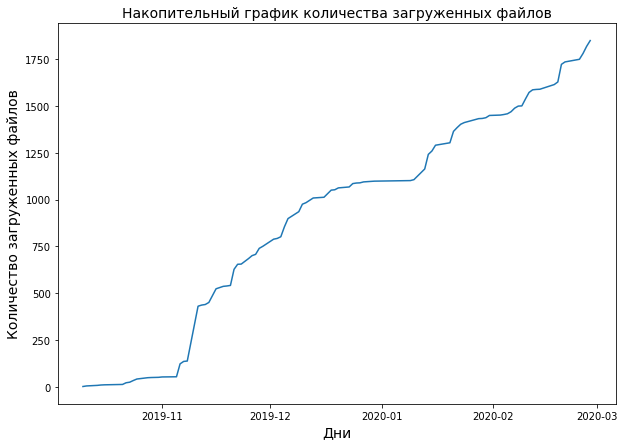

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(x=indexes, y=values, ax=ax)
ax.set_title("Накопительный график количества загруженных файлов", fontsize=14)
ax.set_xlabel("Дни", fontsize=14)
ax.set_ylabel("Количество загруженных файлов", fontsize=14)
plt.show()

__Задание 1.2__
Какой прогноз можно дать по объему файлового хранилища на конец 2020?

Будем исходить из той логики, что количество данных в предсказываемом дне не сильно отличается от среднего количества новых файлов в день в пределах 3 стандартных отклонений от среднего числа новых файлов в день

In [15]:
mean_day_increment = storage_df.date.value_counts().values.mean()
mean_day_increment

21.011363636363637

In [16]:
std_day_increment = storage_df.date.value_counts().values.std()
std_day_increment

35.8372249072049

In [17]:
start_date = str(indexes[-1])
end_date = '2020-12-31'
diff_date = (datetime.date.fromisoformat(end_date) - datetime.date.fromisoformat(start_date)).days

pred_dates = []
pred_values = []

for i in range(diff_date):
    current_date = datetime.date.fromisoformat(start_date) + datetime.timedelta(days=i)
    pred_dates.append(current_date)
    pred_values.append(np.random.normal(loc=mean_day_increment, scale=std_day_increment))

pred_cum_values = np.cumsum(pred_values) + values[-1]

In [18]:
print("Предсказанное значение: " + str(pred_cum_values[-1]))

Предсказанное значение: 7881.9072037089945


__Задание 1.3__
На основании прогноза постройте накопительный график/гистограмму суммарного объёма загруженных файлов помесячно: первые месяцы будут реальные данные, а далее, начиная с марта - прогнозируемый объем. 

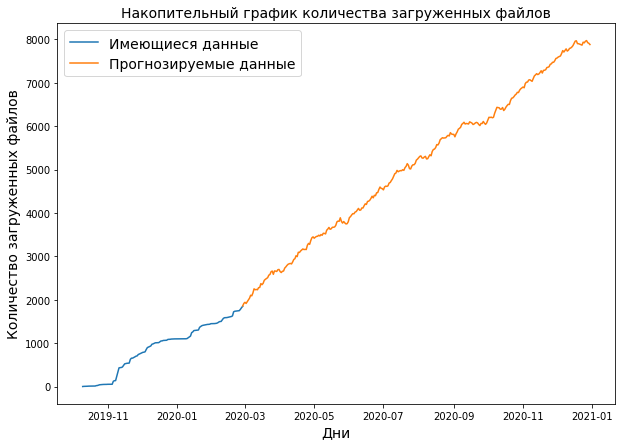

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(x=indexes, y=values, ax=ax, label='Имеющиеся данные')
sns.lineplot(x=pred_dates, y=pred_cum_values, ax=ax, label='Прогнозируемые данные')
ax.set_title("Накопительный график количества загруженных файлов", fontsize=14)
ax.set_xlabel("Дни", fontsize=14)
ax.set_ylabel("Количество загруженных файлов", fontsize=14)
ax.legend(fontsize=14)
plt.show()

## Задание №2

Постройте 2 гистограммы:
* Распределения количества файлов по дням недели
* Распределения количества файлов по часам

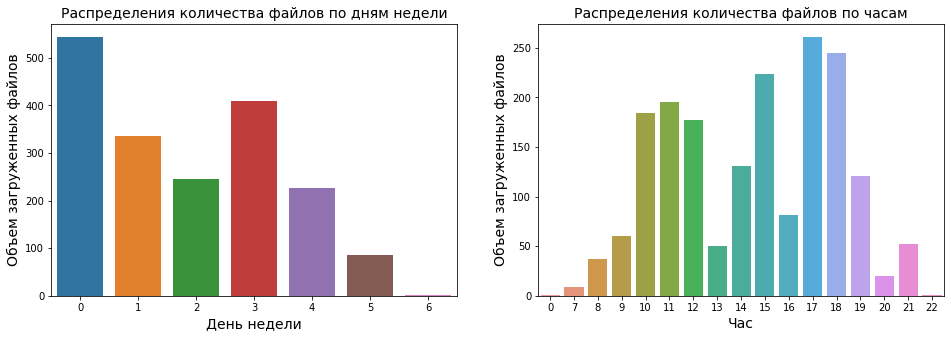

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.countplot(x=storage_df.weekday, ax=axes[0])
axes[0].set_title("Распределения количества файлов по дням недели", fontsize=14)
axes[0].set_xlabel("День недели", fontsize=14)
axes[0].set_ylabel("Объем загруженных файлов", fontsize=14)

sns.countplot(x=storage_df.hour, ax=axes[1])
axes[1].set_title("Распределения количества файлов по часам", fontsize=14)
axes[1].set_xlabel("Час", fontsize=14)
axes[1].set_ylabel("Объем загруженных файлов", fontsize=14)

plt.show()

Понедельник - день тяжелый :)

Распределение количества файлов по дням недели неравномерное. В понедельник и четверг наблюдается пик файлов.

Распределение количества файлов по времени также неравномерное. Пики наблюдаются в дообеденное время (10-12), в 15 часов и вечером (17-18)

## Задание №3

Постройте 2 графика:
* Гистограмму распределения количества файлов в зависимости от раздела.
* Гистограмму распределения размеров файлов по разделам.

In [21]:
storage_df.TypeDocs.unique()

array(['6.Юридические документы', '8.Другие документы',
       '1.Основные документы', '5.Финансовые документы',
       '4.Презентация по проекту', '2.Технические условия',
       '3.Материалы для KYC', '7.Cмешанный проект'], dtype=object)

In [22]:
type_docs_dict = {
    '6.Юридические документы': 'Юридические док-ты',
    '8.Другие документы': 'Другие док-ты',
    '1.Основные документы': 'Основные док-ты',
    '5.Финансовые документы': 'Финансовые док-ты',
    '4.Презентация по проекту': 'Презентации',
    '2.Технические условия': 'Тех. условия',
    '3.Материалы для KYC': 'Материалы для KYC',
    '7.Cмешанный проект': 'Смешанный проект'
}

In [23]:
storage_df.TypeDocs = storage_df.TypeDocs.apply(lambda x: type_docs_dict[x])

Text(0, 0.5, 'Объем загруженных файлов')

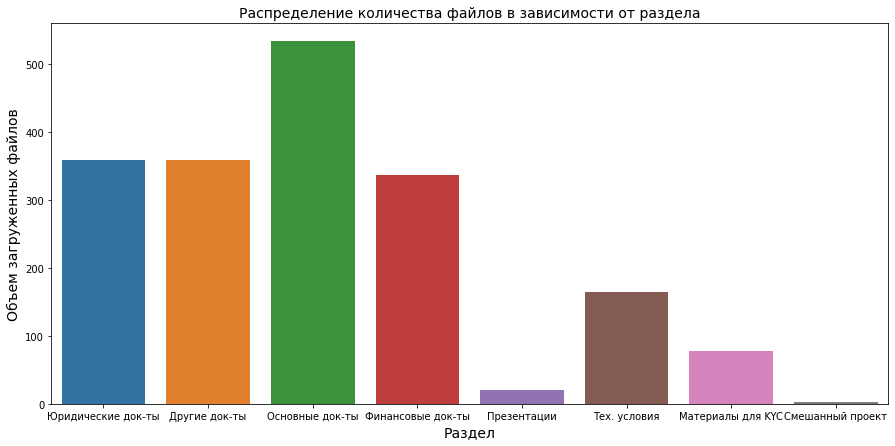

In [24]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.countplot(x='TypeDocs', data=storage_df, ax=ax)
ax.set_title("Распределение количества файлов в зависимости от раздела", fontsize=14)
ax.set_xlabel("Раздел", fontsize=14)
ax.set_ylabel("Объем загруженных файлов", fontsize=14)

## Задание №4

Постройте гистограмму суммарного объёма файлов по проектам.

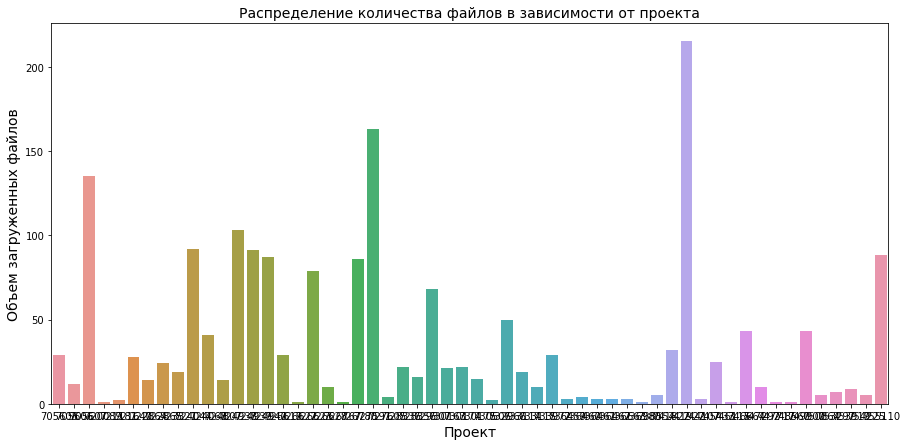

In [25]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.countplot(x='ProjectID', data=storage_df, ax=ax)
ax.set_title("Распределение количества файлов в зависимости от проекта", fontsize=14)
ax.set_xlabel("Проект", fontsize=14)
ax.set_ylabel("Объем загруженных файлов", fontsize=14)
plt.show()

Из всех проектов наиболее выделяется проект с числом файлов, превышающим 200. Исследуем подробнее этот проект

### Проект 741922

In [26]:
project_name = storage_df.ProjectID.value_counts().sort_values(ascending=False).index[0]
project_name

741922

In [27]:
max_project_df = storage_df[storage_df.ProjectID == 741922]
max_project_df.head()

,ProjectID,UserID,CompanyID,FileSize,TypeDocs,year,month,day,weekday,hour,date
14,741922,26996,741921,364279,Юридические док-ты,2020,2,7,4,8,2020-02-07
15,741922,26996,741921,317967,Юридические док-ты,2020,2,10,0,9,2020-02-10
46,741922,26996,741921,738279,Юридические док-ты,2020,2,10,0,9,2020-02-10
54,741922,26996,741921,356344,Юридические док-ты,2020,2,10,0,9,2020-02-10
55,741922,26996,741921,7569429,Юридические док-ты,2020,2,6,3,21,2020-02-06


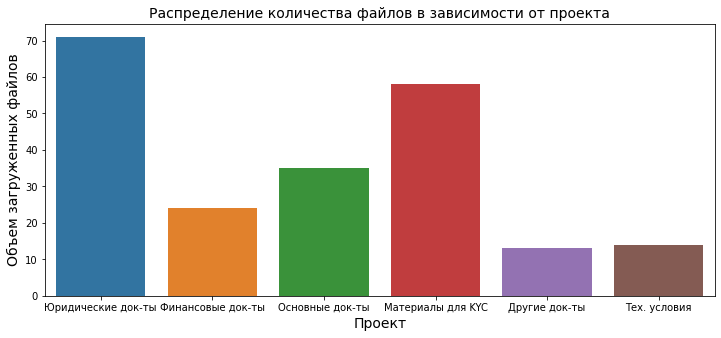

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.countplot(x='TypeDocs', data=max_project_df, ax=ax)
ax.set_title("Распределение количества файлов в зависимости от проекта", fontsize=14)
ax.set_xlabel("Проект", fontsize=14)
ax.set_ylabel("Объем загруженных файлов", fontsize=14)
plt.show()

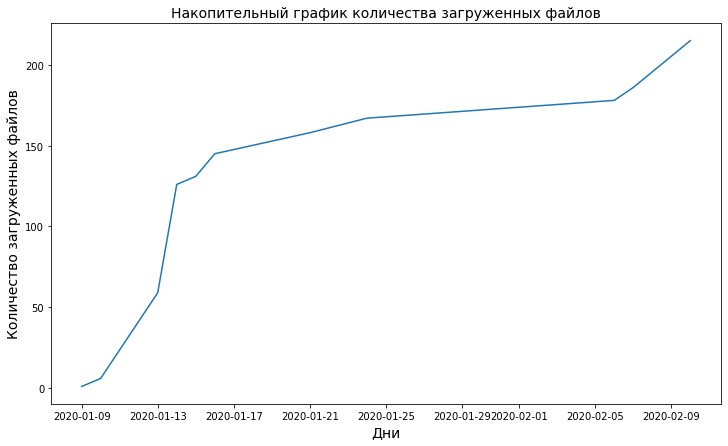

In [29]:
date_series = max_project_df.date.value_counts().sort_index()
indexes = date_series.index
values = np.cumsum(date_series.values)

fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(x=indexes, y=values, ax=ax)
ax.set_title("Накопительный график количества загруженных файлов", fontsize=14)
ax.set_xlabel("Дни", fontsize=14)
ax.set_ylabel("Количество загруженных файлов", fontsize=14)
plt.show()

In [30]:
max_project_df.UserID.value_counts()

26996    215
Name: UserID, dtype: int64

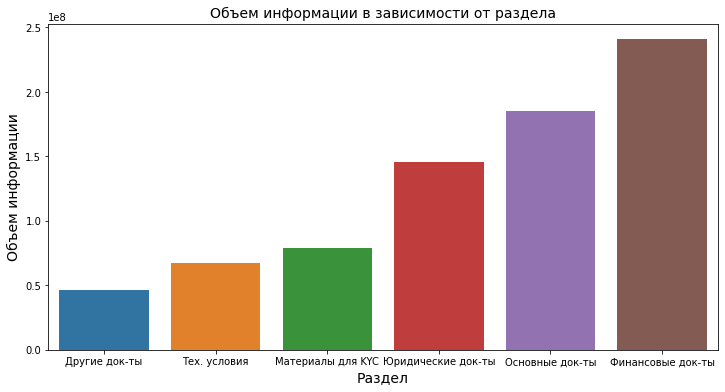

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
filesizes = max_project_df.groupby('TypeDocs')['FileSize'].agg('sum').sort_values()
sns.barplot(x=filesizes.index, y=filesizes.values)

ax.set_title("Объем информации в зависимости от раздела", fontsize=14)
ax.set_xlabel("Раздел", fontsize=14)
ax.set_ylabel("Объем информации", fontsize=14)
plt.show()

Проект ведется месяц одним человеком, в проекте преобладают юридические документы и материалы для KYC

Больше половины документов было создано еще в первую неделю существования проекта

Самые объемные разделы это финансовые и основные документы

## Задание №5

Постройте ящики с усами для размеров загружаемых файлов по компаниям.

In [44]:
company_list = storage_df.CompanyID.unique()
company_list

array([753918, 726615, 703124, 746662, 755109, 722863, 726779, 741921,
       724043, 721639, 721180, 719936, 729353, 727590, 749892, 729306,
       745432, 728333, 724937, 733113, 747716, 747291, 748559, 738553,
       746114, 728355, 723317, 724067, 736979, 733971, 736662, 744106,
       726766, 753296, 727604, 730505], dtype=int64)

In [46]:
len(company_list)

36

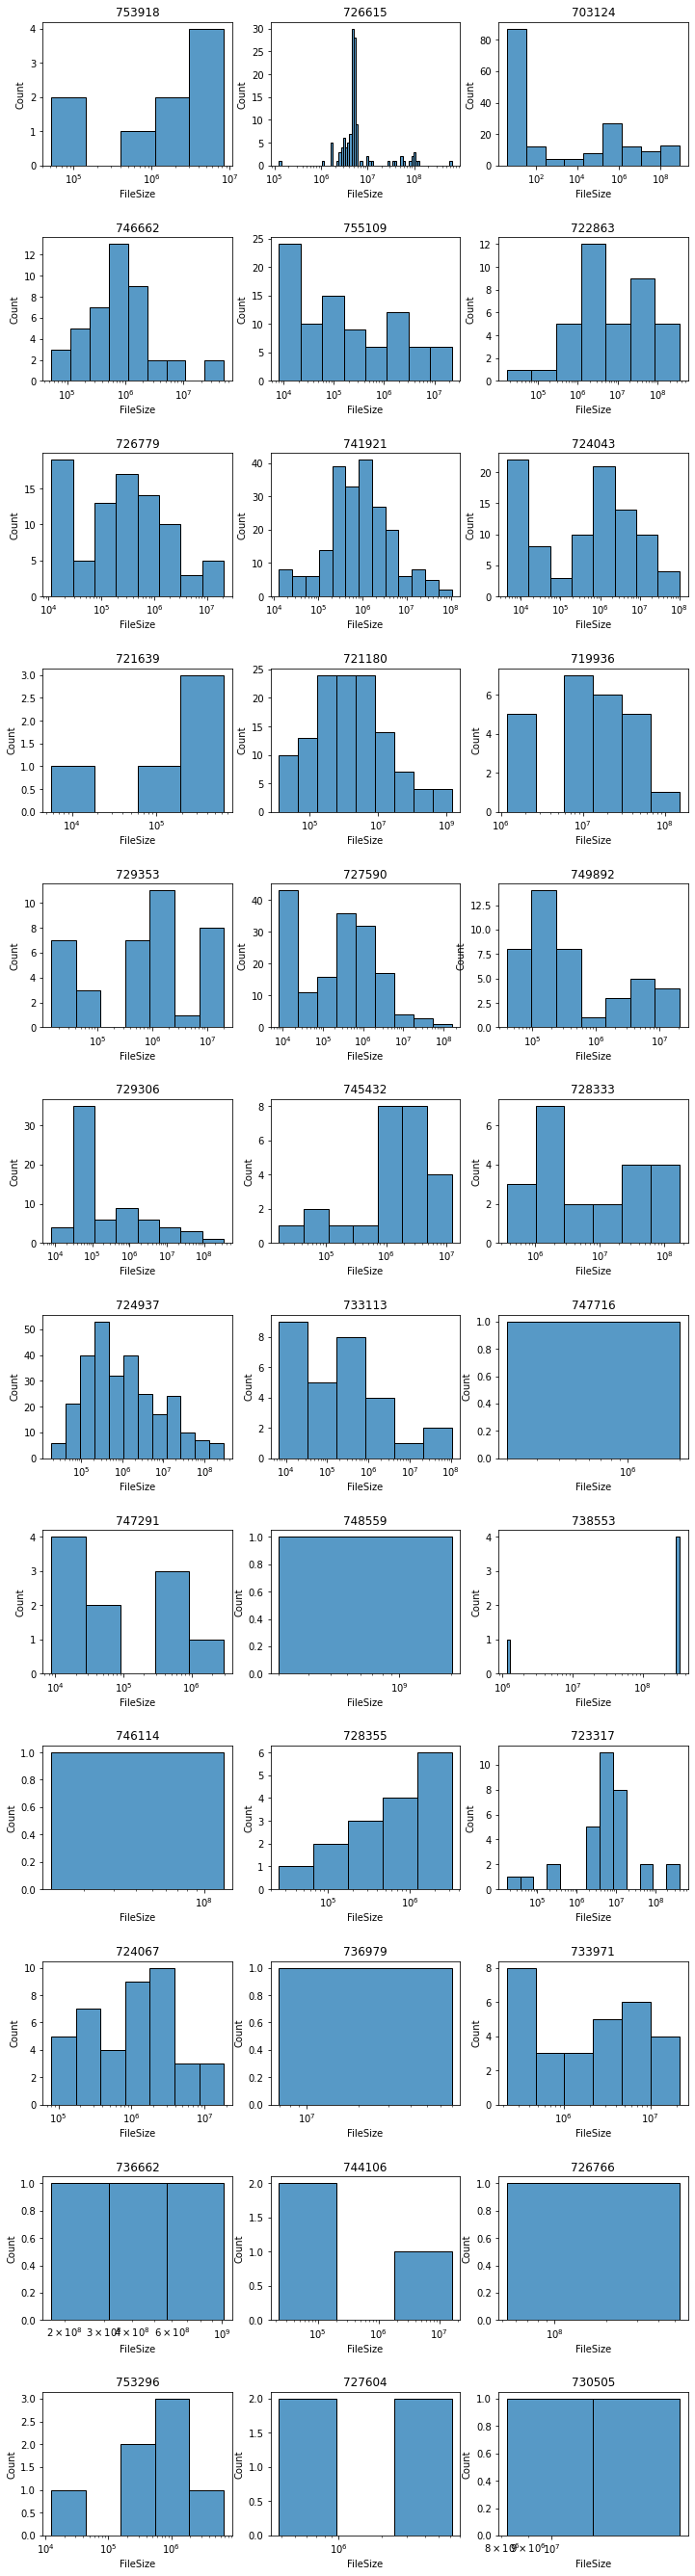

In [57]:
plt.figure(figsize=(12, 48))
plt.subplots_adjust(hspace=0.5)
for i in range(len(company_list)):
    plt.subplot(12, 3, i+1)
    plt.title(str(company_list[i]))
    sns.histplot(x='FileSize', data=storage_df[storage_df.CompanyID==company_list[i]], log_scale=True)